In [1]:
import hydra
import wandb
from ott.neural import datasets
import sys
from omegaconf import DictConfig
import jax.numpy as jnp
from jax import random
from typing import Optional, Literal
import jax
import pathlib
import optax
import yaml
from datetime import datetime
from flax import linen as nn
import functools
from tqdm import tqdm
from flax.training import train_state

from ott.neural.networks.layers import time_encoder
from ott.neural.methods.flows import dynamics, otfm, genot
from ott.neural.networks import velocity_field
from ott.solvers import utils as solver_utils
import jax.tree_util as jtu
from ott.neural.networks.layers import time_encoder
from ott.neural.networks.velocity_field import VelocityField
import pandas as pd
import os

import hydra
from omegaconf import DictConfig, OmegaConf

from torch.utils.data import DataLoader
import numpy as np

import scanpy as sc
from ot_pert.metrics import compute_metrics_fast, compute_mean_metrics
from ot_pert.nets.nets import VelocityFieldWithAttention
from ot_pert.utils import ConditionalLoader


In [2]:
def reconstruct_data(embedding: np.ndarray, projection_matrix: np.ndarray, mean_to_add: np.ndarray) -> np.ndarray:
    return np.matmul(embedding, projection_matrix.T) + mean_to_add

In [3]:
obsm_key_cond = "ecfp_dose_cell_line"
obsm_key_data = "X_pca"

In [4]:
adata_train_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_train_30.h5ad"
adata_test_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_test_30.h5ad"
adata_ood_path = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_ood_30.h5ad"

In [5]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [6]:
sc.pp.subsample(adata_train, fraction=0.3)

In [7]:
adata_train.obsm["ecfp_dose"] = np.concatenate(
    (adata_train.obsm["ecfp"], np.asarray(adata_train.obs["dose"])[:, None]), axis=1
)
adata_test.obsm["ecfp_dose"] = np.concatenate(
    (adata_test.obsm["ecfp"], np.asarray(adata_test.obs["dose"])[:, None]), axis=1
)
adata_ood.obsm["ecfp_dose"] = np.concatenate(
    (adata_ood.obsm["ecfp"], np.asarray(adata_ood.obs["dose"])[:, None]), axis=1
)

In [8]:
adata_train.obsm["ecfp_dose_cell_line"] = np.concatenate(
    (adata_train.obsm["ecfp_dose"], adata_train.obsm["cell_line_emb"]), axis=1
)
adata_test.obsm["ecfp_dose_cell_line"] = np.concatenate(
    (adata_test.obsm["ecfp_dose"], adata_test.obsm["cell_line_emb"]), axis=1
)
adata_ood.obsm["ecfp_dose_cell_line"] = np.concatenate(
    (adata_ood.obsm["ecfp_dose"], adata_ood.obsm["cell_line_emb"]), axis=1
)

In [9]:
def data_match_fn(
    src_lin: Optional[jnp.ndarray], tgt_lin: Optional[jnp.ndarray],
    src_quad: Optional[jnp.ndarray], tgt_quad: Optional[jnp.ndarray], *,
    typ: Literal["lin", "quad", "fused"], epsilon: float = 1e-2, tau_a: float = 1.0,
    tau_b: float = 1.0,
) -> jnp.ndarray:
    if typ == "lin":
        return solver_utils.match_linear(x=src_lin, y=tgt_lin, scale_cost="mean", epsilon=epsilon, tau_a=tau_a, tau_b=tau_b)
    if typ == "quad":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad)
    if typ == "fused":
        return solver_utils.match_quadratic(
            xx=src_quad, yy=tgt_quad, x=src_lin, y=tgt_lin
        )
    raise NotImplementedError(f"Unknown type: {typ}.")

# Load data

dls = []

train_data_source = {}
train_data_target = {}
train_data_source_decoded = {}
train_data_target_decoded = {}
train_data_conditions = {}


for cond in adata_train.obs["condition"].cat.categories:
    if "Vehicle" in cond:
        continue
    src_str = list(adata_train[adata_train.obs["condition"]==cond].obs["cell_type"].unique())
    assert len(src_str) == 1
    source = adata_train[adata_train.obs["condition"]==src_str[0]+"_Vehicle_0.0"].obsm[obsm_key_data]
    source_decoded = adata_train[adata_train.obs["condition"]==src_str[0]+"_Vehicle_0.0"].X.A
    target = adata_train[adata_train.obs["condition"]==cond].obsm[obsm_key_data]
    target_decoded = adata_train[adata_train.obs["condition"]==cond].X.A
    conds = adata_train[adata_train.obs["condition"]==cond].obsm[obsm_key_cond]
    assert np.all(np.all(conds == conds[0], axis=1))
    conds = np.tile(conds[0], (len(source), 1))
    dls.append(DataLoader(datasets.OTDataset(datasets.OTData(
        lin=source,
        condition=conds,
    ), datasets.OTData(lin=target)), batch_size=1024, shuffle=True))
    train_data_source[cond] = source
    train_data_target[cond] = target
    train_data_conditions[cond] = conds
    train_data_source_decoded[cond] = source_decoded
    train_data_target_decoded[cond] = target_decoded

train_loader = ConditionalLoader(dls, seed=0)

test_data_source = {}
test_data_target = {}
test_data_source_decoded = {}
test_data_target_decoded = {}
test_data_conditions = {}

for cond in adata_test.obs["condition"].cat.categories:
    if "Vehicle" in cond:
        continue
    src_str = list(adata_test[adata_test.obs["condition"]==cond].obs["cell_type"].unique())
    assert len(src_str) == 1
    source = adata_test[adata_test.obs["condition"]==src_str[0]+"_Vehicle_0.0"].obsm[obsm_key_data]
    source_decoded = adata_test[adata_test.obs["condition"]==src_str[0]+"_Vehicle_0.0"].X.A

    target = adata_test[adata_test.obs["condition"]==cond].obsm[obsm_key_data]
    target_decoded = adata_test[adata_test.obs["condition"]==cond].X.A


    conds = adata_test[adata_test.obs["condition"]==cond].obsm[obsm_key_cond]
    assert np.all(np.all(conds == conds[0], axis=1))
    conds = np.tile(conds[0], (len(source), 1))
    test_data_source[cond] = source
    test_data_target[cond] = target
    test_data_source_decoded[cond] = source_decoded
    test_data_target_decoded[cond] = target_decoded
    test_data_conditions[cond] = conds

ood_data_source = {}
ood_data_target = {}
ood_data_source_decoded = {}
ood_data_target_decoded = {}
ood_data_conditions = {}

for cond in adata_ood.obs["condition"].cat.categories:
    if "Vehicle" in cond:
        continue
    src_str = list(adata_ood[adata_ood.obs["condition"]==cond].obs["cell_type"].unique())
    assert len(src_str) == 1
    source = adata_ood[adata_ood.obs["condition"]==src_str[0]+"_Vehicle_0.0"].obsm[obsm_key_data]
    source_decoded = adata_ood[adata_ood.obs["condition"]==src_str[0]+"_Vehicle_0.0"].X.A
    target = adata_ood[adata_ood.obs["condition"]==cond].obsm[obsm_key_data]
    target_decoded = adata_ood[adata_ood.obs["condition"]==cond].X.A
    conds = adata_ood[adata_ood.obs["condition"]==cond].obsm[obsm_key_cond]
    assert np.all(np.all(conds == conds[0], axis=1))
    conds = np.tile(conds[0], (len(source), 1))
    ood_data_source[cond] = source
    ood_data_target[cond] = target
    ood_data_source_decoded[cond] = source_decoded
    ood_data_target_decoded[cond] = target_decoded
    ood_data_conditions[cond] = conds

reconstruct_data_fn = functools.partial(reconstruct_data, projection_matrix=adata_train.varm["PCs"], mean_to_add=adata_train.varm["X_train_mean"].T)


2024-04-24 14:07:51.618117: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [10]:
reconstruct_data_fn = functools.partial(reconstruct_data, projection_matrix=adata_train.varm["PCs"], mean_to_add=adata_train.varm["X_train_mean"].T)

train_deg_dict = {k: v for k,v in adata_train.uns['rank_genes_groups_cov_all'].items() if k in train_data_conditions.keys()}
test_deg_dict = {k: v for k,v in adata_train.uns['rank_genes_groups_cov_all'].items() if k in test_data_conditions.keys()}
ood_deg_dict = {k: v for k,v in adata_train.uns['rank_genes_groups_cov_all'].items() if k in ood_data_conditions.keys()}

def get_mask(x, y):
    return x[:, [gene in y for gene in adata_train.var_names]]

In [11]:
source_dim = source.shape[1]
target_dim = source_dim
condition_dim = conds.shape[1]

source_dim = source.shape[1]
target_dim = source_dim
condition_dim = conds.shape[1]

In [12]:
from typing import Callable, Optional, Sequence

import jax.numpy as jnp

from flax import linen as nn

from ott.neural.networks.layers import time_encoder
from ot_pert.nets.nets import CondVelocityField

In [13]:
vf = CondVelocityField(
    hidden_dims=[1024, 1024, 1024],
    time_dims=[512,512],
    output_dims=[1024, 1024, 1024]+[target_dim],
    condition_dims=[2048, 2048],
    time_encoder = functools.partial(time_encoder.cyclical_time_encoder, n_freqs=1024),
    dropout_rate=0.2
    )

model = genot.GENOT(
    vf,
    flow=dynamics.ConstantNoiseFlow(0.0),
    data_match_fn=jax.jit(functools.partial(data_match_fn, typ="lin", src_quad=None, tgt_quad=None)),
    source_dim=source_dim,
    target_dim=target_dim,
    condition_dim=condition_dim,
    rng=jax.random.PRNGKey(13),
    optimizer=optax.MultiSteps(optax.adam(learning_rate=1e-4), 20),)
training_logs = {"loss": []}

In [14]:
import functools
import sys
import traceback
from typing import Optional, Literal, Tuple, Dict
import hydra
import jax
import jax.numpy as jnp
import jax.tree_util as jtu
import numpy as np
import optax
import scanpy as sc
import wandb
from omegaconf import DictConfig, OmegaConf
from ott.neural import datasets
from ott.neural.methods.flows import dynamics, genot
from ott.neural.networks.layers import time_encoder
from ott.neural.networks.velocity_field import VelocityField
from ott.solvers import utils as solver_utils
from torch.utils.data import DataLoader
from tqdm import tqdm
import orbax
import os

def prepare_data(
    batch: Dict[str, jnp.ndarray]
    ) -> Tuple[Tuple[jnp.ndarray, Optional[jnp.ndarray], jnp.ndarray],
            Tuple[jnp.ndarray, jnp.ndarray, Optional[jnp.ndarray],
                    Optional[jnp.ndarray]]]:
    src_lin, src_quad = batch.get("src_lin"), batch.get("src_quad")
    tgt_lin, tgt_quad = batch.get("tgt_lin"), batch.get("tgt_quad")

    if src_quad is None and tgt_quad is None:  # lin
        src, tgt = src_lin, tgt_lin
        arrs = src_lin, tgt_lin
    elif src_lin is None and tgt_lin is None:  # quad
        src, tgt = src_quad, tgt_quad
        arrs = src_quad, tgt_quad
    elif all(
        arr is not None for arr in (src_lin, tgt_lin, src_quad, tgt_quad)
    ):  # fused quad
        src = jnp.concatenate([src_lin, src_quad], axis=1)
        tgt = jnp.concatenate([tgt_lin, tgt_quad], axis=1)
        arrs = src_quad, tgt_quad, src_lin, tgt_lin
    else:
        raise RuntimeError("Cannot infer OT problem type from data.")

    return (src, batch.get("src_condition"), tgt), arrs

In [15]:


rng = jax.random.PRNGKey(0)
for it in tqdm(range(50000)):
    batch = next(iter(train_loader))
    batch = jtu.tree_map(jnp.asarray, batch)
    rng = jax.random.split(rng, 5)
    rng, rng_resample, rng_noise, rng_time, rng_step_fn = rng
    
    batch = jtu.tree_map(jnp.asarray, batch)
    (src, src_cond, tgt), matching_data = prepare_data(batch)
    
    n = src.shape[0]
    time = model.time_sampler(rng_time, n * model.n_samples_per_src)
    latent = model.latent_noise_fn(rng_noise, (n, model.n_samples_per_src))
    
    tmat = model.data_match_fn(*matching_data)  # (n, m)
    src_ixs, tgt_ixs = solver_utils.sample_conditional(  # (n, k), (m, k)
    rng_resample,
    tmat,
    k=model.n_samples_per_src,
    )
    
    src, tgt = src[src_ixs], tgt[tgt_ixs]  # (n, k, ...),  # (m, k, ...)
    if src_cond is not None:
        src_cond = src_cond[src_ixs]
    
    if model.latent_match_fn is not None:
        src, src_cond, tgt = model._match_latent(rng, src, src_cond, latent, tgt)
    
    src = src.reshape(-1, *src.shape[2:])  # (n * k, ...)
    tgt = tgt.reshape(-1, *tgt.shape[2:])  # (m * k, ...)
    latent = latent.reshape(-1, *latent.shape[2:])
    if src_cond is not None:
        src_cond = src_cond.reshape(-1, *src_cond.shape[2:])

    
    
    loss, model.vf_state = model.step_fn(
    rng_step_fn, model.vf_state, time, src, tgt, latent, src_cond
    )

    training_logs["loss"].append(float(loss))
    if (it % 100000 == 0) and (it > 0):
        idcs = np.random.choice(list(test_data_source.keys()), 20)
        test_data_source_tmp = {k:v for k,v in test_data_source.items() if k in idcs}
        test_data_target_tmp = {k:v for k,v in test_data_target.items() if k in idcs}
        test_data_conditions_tmp = {k:v for k,v in test_data_conditions.items() if k in idcs}
        test_data_target_decoded_tmp = {k:v for k,v in test_data_target_decoded.items() if k in idcs}
        test_deg_dict_tmp = {k:v for k,v in test_deg_dict.items() if k in idcs}
        valid_losses = []
        #for cond in test_data_source_tmp.keys():
        #    src = test_data_source_tmp[cond]
        #    tgt = test_data_target_tmp[cond]
        #    src_cond = test_data_conditions_tmp[cond]
        #    if model.match_fn is not None:
        #        tmat = model.match_fn(src, tgt)
        #        src_ixs, tgt_ixs = solver_utils.sample_joint(rng_resample, tmat)
        #        src, tgt = src[src_ixs], tgt[tgt_ixs]
        #        src_cond = None if src_cond is None else src_cond[src_ixs]
        #    _, valid_loss = model.step_fn(
        #        rng,
        #        model.vf_state,
        #        src,
        #        tgt,
        #        src_cond,
        #    )
        #    valid_losses.append(valid_loss)

        # predicted_target_train = jax.tree_util.tree_map(model.transport, train_data_source, train_data_conditions)
        # train_metrics = jax.tree_util.tree_map(compute_metrics_fast, train_data_target, predicted_target_train)
        # mean_train_metrics = compute_mean_metrics(train_metrics, prefix="train_")

        # predicted_target_train_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_train)
        # train_metrics_decoded = jax.tree_util.tree_map(compute_metrics_fast, train_data_target_decoded, predicted_target_train_decoded)
        # mean_train_metrics_decoded = compute_mean_metrics(train_metrics_decoded, prefix="decoded_train_")

        # train_deg_target_decoded_predicted = jax.tree_util.tree_map(get_mask, predicted_target_train_decoded, train_deg_dict)
        # train_deg_target_decoded = jax.tree_util.tree_map(get_mask, train_data_target_decoded, test_deg_dict)

        predicted_target_test = jax.tree_util.tree_map(model.transport, test_data_source_tmp, test_data_conditions_tmp)
        #test_metrics = jax.tree_util.tree_map(compute_metrics_fast, test_data_target_tmp, predicted_target_test)
        #mean_test_metrics = compute_mean_metrics(test_metrics, prefix="test_")

        predicted_target_test_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_test)
        test_metrics_decoded = jax.tree_util.tree_map(
            compute_metrics_fast, test_data_target_decoded_tmp, predicted_target_test_decoded
        )
        mean_test_metrics_decoded = compute_mean_metrics(test_metrics_decoded, prefix="decoded_test_")


        #test_deg_target_decoded_predicted = jax.tree_util.tree_map(
        #    get_mask, predicted_target_test_decoded, test_deg_dict_tmp
        #)
        #test_deg_target_decoded = jax.tree_util.tree_map(get_mask, test_data_target_decoded_tmp, test_deg_dict_tmp)
        #deg_test_metrics_encoded = jax.tree_util.tree_map(
        #    compute_metrics_fast, test_deg_target_decoded, test_deg_target_decoded_predicted
        #)
        #deg_mean_test_metrics_encoded = compute_mean_metrics(deg_test_metrics_encoded, prefix="deg_test_")

        predicted_target_ood = jax.tree_util.tree_map(model.transport, ood_data_source, ood_data_conditions)
        ood_metrics = jax.tree_util.tree_map(compute_metrics_fast, ood_data_target, predicted_target_ood)
        mean_ood_metrics = compute_mean_metrics(ood_metrics, prefix="ood_")

        predicted_target_ood_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_ood)
        ood_metrics_decoded = jax.tree_util.tree_map(
            compute_metrics_fast, ood_data_target_decoded, predicted_target_ood_decoded
        )
        mean_ood_metrics_decoded = compute_mean_metrics(ood_metrics_decoded, prefix="decoded_ood_")

        #ood_deg_target_decoded_predicted = jax.tree_util.tree_map(
        #    get_mask, predicted_target_ood_decoded, ood_deg_dict
        #)
        #ood_deg_target_decoded = jax.tree_util.tree_map(get_mask, ood_data_target_decoded, ood_deg_dict)
        #deg_ood_metrics_encoded = jax.tree_util.tree_map(
        #    compute_metrics_fast, ood_deg_target_decoded, ood_deg_target_decoded_predicted
        #)
        #deg_mean_ood_metrics_encoded = compute_mean_metrics(deg_ood_metrics_encoded, prefix="deg_ood_")
        print(mean_test_metrics_decoded, mean_ood_metrics_decoded)


 45%|████▌     | 22710/50000 [50:42<1:00:56,  7.46it/s]


KeyboardInterrupt: 

In [ ]:
predicted_target_ood = jax.tree_util.tree_map(model.transport, ood_data_source, ood_data_conditions)
ood_metrics = jax.tree_util.tree_map(compute_metrics_fast, ood_data_target, predicted_target_ood)
mean_ood_metrics = compute_mean_metrics(ood_metrics, prefix="ood_")

predicted_target_ood_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_ood)
ood_metrics_decoded = jax.tree_util.tree_map(
    compute_metrics_fast, ood_data_target_decoded, predicted_target_ood_decoded
)
mean_ood_metrics_decoded = compute_mean_metrics(ood_metrics_decoded, prefix="decoded_ood_")

In [ ]:
mean_ood_metrics

In [ ]:
mean_ood_metrics_decoded

In [41]:
ood_data_conditions_inp = jax.tree_util.tree_map(lambda x,y: jnp.concatenate((x,y), axis=1), train_data_source, train_data_conditions)

In [42]:
embs = jax.tree_util.tree_map(lambda x: vf.get_embedding(model.vf_state, x[0:1]), ood_data_conditions_inp)

In [43]:
embs_ls = [v for v in embs.values()]

In [44]:
emb = np.concatenate(embs_ls, axis=0)

In [45]:
emb.shape

(1275, 2048)

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

In [47]:
similarity_matrix = cosine_similarity(emb)
np.fill_diagonal(similarity_matrix, 1.0)
X = KernelPCA(n_components=2, kernel="precomputed") \
    .fit_transform(similarity_matrix)

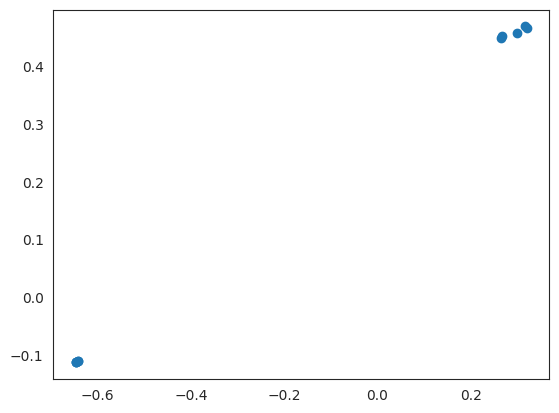

In [48]:
plt.scatter(X[:10,0], X[:10,1])

In [54]:
df_conditions = adata_train[adata_train.obs["condition"].isin(list(embs.keys()))].obs.drop_duplicates(subset=["condition"])

In [55]:
def get_dose_color(x):
    dose = x["dose"]
    if dose==10.0:
        return "#f7e5e4"
    if dose == 100.0:
        return "#f29f99"
    if dose == 1000.0:
        return "#f5675d"
    if dose == 10000.0:
        return "#f01405"
df_conditions["dose_color"] = df_conditions.apply(get_dose_color, axis=1)

/tmp/ipykernel_649664/2509494363.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conditions["dose_color"] = df_conditions.apply(get_dose_color, axis=1)


In [56]:
col_dict_dose = df_conditions.set_index("condition")['dose_color'].to_dict()

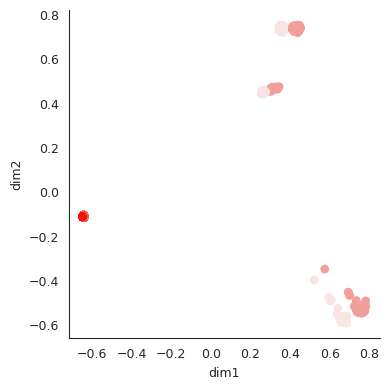

In [57]:
import seaborn as sns
import pandas as pd
from adjustText import adjust_text

plot_embedding(X, labels=np.array(list(embs.keys())), show_text=False, col_dict=col_dict_dose)


In [58]:
def get_cell_line_color(x):
    cell_line=x["cell_line"]
    if cell_line=="MCF7":
        return "#38f005"
    if cell_line=="K562":
        return "#cc05f0"
    if cell_line == "A549":
        return "#058af0"
    
df_conditions["cell_line_color"] = df_conditions.apply(get_cell_line_color, axis=1)

In [59]:
col_dict_cell_line = df_conditions.set_index("condition")['cell_line_color'].to_dict()

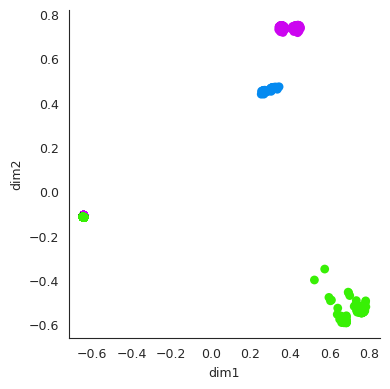

In [60]:
from ot_pert.plotting import plot_embedding
plot_embedding(X, labels=np.array(list(embs.keys())), show_text=False, col_dict=col_dict_cell_line)

In [ ]:
predicted_target_ood = jax.tree_util.tree_map(model.transport, ood_data_source, ood_data_conditions)
ood_metrics = jax.tree_util.tree_map(compute_metrics_fast, ood_data_target, predicted_target_ood)
mean_ood_metrics = compute_mean_metrics(ood_metrics, prefix="ood_")

predicted_target_ood_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_ood)
ood_metrics_decoded = jax.tree_util.tree_map(
    compute_metrics_fast, ood_data_target_decoded, predicted_target_ood_decoded
)
mean_ood_metrics_decoded = compute_mean_metrics(ood_metrics_decoded, prefix="decoded_ood_")

In [ ]:
mean_ood_metrics_decoded